<a href="https://colab.research.google.com/github/MutianWang/novel-cell/blob/main/human/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novel Cells Generation

In [183]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/Colab Notebooks/Brain Cell/data/'

## Preprocessing

In [ ]:
meta = pd.read_csv(path+'meta.csv', header=0)
cols_glut = meta[meta['class']=='Glutamatergic']['sample_name']
cols_non = meta[meta['class']=='Non-neuronal']['sample_name']
cols_gaba = meta[meta['class']=='GABAergic']['sample_name']

In [ ]:
def normalize(df):
    # counts per million
    df = df.div(df.sum(axis=1), axis=0) * 10**6
    df = df.fillna(0)
    return df

In [ ]:
def read_expression(file1, file2, usecols):
    # point-wise addition of exon and intron tables
    reader1 = pd.read_csv(file1, header=0, usecols=usecols, chunksize=1000)
    reader2 = pd.read_csv(file2, header=0, usecols=usecols, chunksize=1000)

    df = reader1.get_chunk() + reader2.get_chunk()
    for i in range(1, 51):
        df = pd.concat([df, reader1.get_chunk() + reader2.get_chunk()])
        if i%10==0:
            print('{}/50'.format(i))

    return df.transpose()

In [ ]:
exp_glut = read_expression(path+'exon.csv', path+'intron.csv', cols_glut) # 10525 * 50281
exp_glut = exp_glut.sample(5000-914) # 4086 * 50281
exp_glut = normalize(exp_glut)
np.save(path+'exp_glut', exp_glut)
del exp_glut

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_non = read_expression(path+'exon.csv', path+'intron.csv', cols_non) # 914 * 50281
exp_non = normalize(exp_non)
np.save(path+'exp_non', exp_non)
del exp_non

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_gaba = read_expression(path+'exon.csv', path+'intron.csv', cols_gaba) # 4164 * 50281
exp_gaba = normalize(exp_gaba)
np.save(path+'exp_gaba', exp_gaba)
del exp_gaba

10/50
20/50
30/50
40/50
50/50


In [ ]:
# first 4086 are Glutamatergic, last 914 are Non-neuronal
exp_train = np.concatenate([np.load(path+'exp_glut.npy'), 
                            np.load(path+'exp_non.npy')], axis=0)
np.save(path+'exp_train', exp_train)

## Dimension Reduction

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [6]:
pipe = Pipeline([('scaler1', StandardScaler()), ('pca', PCA(n_components=4000)), ('scaler2', MinMaxScaler())])

In [8]:
exp_train = np.load(path+'exp_train.npy')
exp_train = pipe.fit_transform(exp_train)
np.save(path+'exp_train_pca', exp_train)
del exp_train

In [9]:
exp_test = np.load(path+'exp_gaba.npy')
exp_test = pipe.transform(exp_test)
np.save(path+'exp_test_pca', exp_test)
del exp_test

## GAN

In [10]:
exp_train = np.load(path+'exp_train_pca.npy')

In [11]:
dimension = exp_train.shape[1]

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(2048, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # sigmoid function will make the range [0,1]
    model.add(layers.Dense(dimension, use_bias=True, activation='sigmoid'))

    return model

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, use_bias=True, input_shape=(dimension,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))

    return model

In [15]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              4097024   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 128])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for data in dataset:
            train_step(data)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [23]:
BATCH_SIZE = 500
dataset = tf.data.Dataset.from_tensor_slices(exp_train).shuffle(1000).batch(BATCH_SIZE)

In [24]:
train(dataset, 15)

Time for epoch 1 is 2.8146238327026367 sec
Time for epoch 2 is 0.8934121131896973 sec
Time for epoch 3 is 0.8913373947143555 sec
Time for epoch 4 is 0.9321537017822266 sec
Time for epoch 5 is 0.8856215476989746 sec
Time for epoch 6 is 0.9008388519287109 sec
Time for epoch 7 is 0.8939552307128906 sec
Time for epoch 8 is 0.8880393505096436 sec
Time for epoch 9 is 0.8698074817657471 sec
Time for epoch 10 is 0.8574795722961426 sec
Time for epoch 11 is 0.8406703472137451 sec
Time for epoch 12 is 0.8422796726226807 sec
Time for epoch 13 is 0.8420355319976807 sec
Time for epoch 14 is 0.8437275886535645 sec
Time for epoch 15 is 0.8395957946777344 sec


In [25]:
exp_gen = generator(tf.random.normal([1000,128]))

## Evaluation

### Nearest Neighbor

In [26]:
from scipy.spatial import distance

In [37]:
def distance_classify(metric, centers, gens):
    if metric == 'l1':
        dist = lambda x, y: np.sum(np.abs(x-y))
    elif metric == 'l2':
        dist = lambda x, y: np.sum(np.square(x-y))
    elif metric == 'cosine' or metric == 'cos':
        dist = lambda x, y: distance.cosine(x, y)
    else:
        return

    res = [0, 0, 0]
    res1 = []
    res2 = []
    res3 = []
    for gen in gens:
        res1.append(dist(gen, centers[0]))
        res2.append(dist(gen, centers[1]))
        res3.append(dist(gen, centers[2]))

        i = np.argmin([res1[-1], res2[-1], res3[-1]])
        res[i] += 1

    return res


#### mean center

In [38]:
mean_glut = np.mean(np.load(path+'exp_train_pca.npy')[:4086], axis=0)
mean_non = np.mean(np.load(path+'exp_train_pca.npy')[4086:], axis=0)
mean_gaba = np.mean(np.load(path+'exp_test_pca.npy'), axis=0)

mean_centers = [mean_glut, mean_non, mean_gaba]

In [40]:
# L1 distance
res = distance_classify('l1', mean_centers, exp_gen)
print(res)

[229, 138, 633]


In [41]:
# L2 distance
res = distance_classify('l2', mean_centers, exp_gen)
print(res)

[848, 152, 0]


In [42]:
# cosine distance
res = distance_classify('cosine', mean_centers, exp_gen)
print(res)

[884, 116, 0]


#### median center

In [43]:
median_glut = np.median(np.load(path+'exp_train_pca.npy')[:4086], axis=0)
median_non = np.median(np.load(path+'exp_train_pca.npy')[4086:], axis=0)
median_gaba = np.median(np.load(path+'exp_test_pca.npy'), axis=0)

median_centers = [median_glut, median_non, median_gaba]

In [46]:
# L1 distance
res = distance_classify('l1', median_centers, exp_gen)
print(res)

[306, 63, 631]


In [47]:
# L2 distance
res = distance_classify('l2', median_centers, exp_gen)
print(res)

[912, 88, 0]


In [48]:
# cosine distance
res = distance_classify('cosine', median_centers, exp_gen)
print(res)

[955, 45, 0]


### PCA + Visualization

#### 2D

In [203]:
exp_pca = np.concatenate([np.load(path+'exp_train_pca.npy'),
                          np.load(path+'exp_test_pca.npy')], axis=0)

In [204]:
pipe2 = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

In [205]:
exp_pca = pipe2.fit_transform(exp_pca)

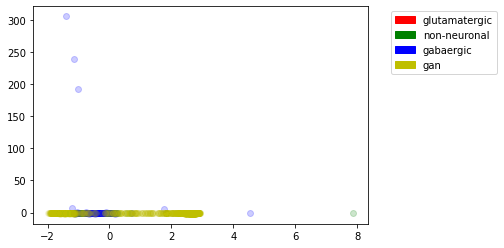

In [210]:
# red: glutamatergic
x, y = list(zip(*exp_pca[3000:3200]))
plt.scatter(x, y, c='r', alpha=0.2)
# green: non-neuronal
x, y = list(zip(*exp_pca[4700:4900]))
plt.scatter(x, y, c='g', alpha=0.2)
# blue: gabaergic
# some blue points are far away because 1st pca didn't see gaba data
x, y = list(zip(*exp_pca[7000:7200]))
plt.scatter(x, y, c='b', alpha=0.2)
# yellow: gan
x, y = list(zip(*pipe2.transform(exp_gen)))
plt.scatter(x, y, c='y', alpha=0.1);

patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
patch4 = mpatches.Patch(color='y', label='gan');
plt.legend(handles=[patch1, patch2, patch3, patch4], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()

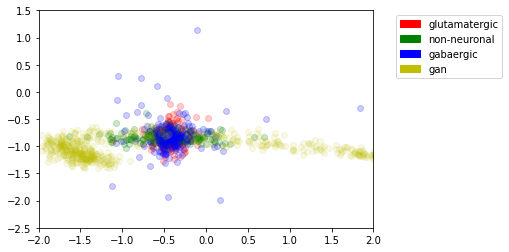

In [209]:
# red: glutamatergic
x, y = list(zip(*exp_pca[3000:3200]))
plt.scatter(x, y, c='r', alpha=0.2);
# green: non-neuronal
x, y = list(zip(*exp_pca[4700:4900]))
plt.scatter(x, y, c='g', alpha=0.2);
# blue: gabaergic
x, y = list(zip(*exp_pca[7000:7200]))
plt.scatter(x, y, c='b', alpha=0.2);
# yellow: gan
x, y = list(zip(*pipe2.transform(exp_gen)))
plt.scatter(x, y, c='y', alpha=0.1);

plt.xlim(-2, 2);
plt.ylim(-2.5, 1.5);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
patch4 = mpatches.Patch(color='y', label='gan');
plt.legend(handles=[patch1, patch2, patch3, patch4], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()

#### 3D

In [199]:
exp_pca = np.concatenate([np.load(path+'exp_train_pca.npy'),
                          np.load(path+'exp_test_pca.npy')], axis=0)

In [200]:
pipe3 = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=3))])

In [201]:
exp_pca = pipe3.fit_transform(exp_pca)

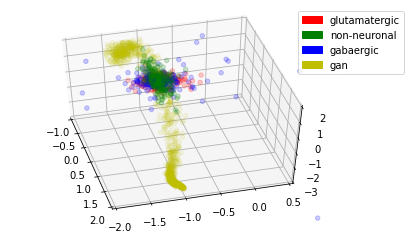

In [202]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# red: glutamatergic
x, y, z = list(zip(*exp_pca[3000:3200]))
ax.scatter3D(x, y, z, c='r', alpha=0.2);
# green: non-neuronal
x, y, z = list(zip(*exp_pca[4700:4900]))
ax.scatter3D(x, y, z, c='g', alpha=0.2);
# blue: gabaergic
x, y, z = list(zip(*exp_pca[7000:7200]))
ax.scatter3D(x, y, z, c='b', alpha=0.2);
# yellow: gan
x, y, z = list(zip(*pipe3.transform(exp_gen)))
ax.scatter3D(x, y, z, c='y', alpha=0.1);

ax.set_xlim(-1,2.0);
ax.set_ylim(-2,0.5);
ax.set_zlim(-3,2);
ax.view_init(50, -15);

patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
patch4 = mpatches.Patch(color='y', label='gan');
plt.legend(handles=[patch1, patch2, patch3, patch4], 
           loc='upper right', bbox_to_anchor=(1.2, 1));
plt.show();